# Analysis of ALMA NGC 253 Data for Density Tracing Species
## 1. Data Cube Processing Step 1

### Importing Necessary Python packages you will be using

In [207]:
#Use this window to import packages you will use later
#When you first start working or import a new package, this cell needs to be run before doing anything else.


import numpy as np                          # I use this for maths and sometimes arrays.
                                            # "np" is just an abbreviation since we call this package so often!
import pylab                                # I use this for arrays and plotting
import matplotlib                           # Another plotting package
import matplotlib.gridspec as gridspec      # If there is a task you use a lot, importing it like this 
                                            # keeps you from having to constantly type "matplotlib.gridspec"
                                            # every time you call that task!
import scipy

import astropy.io.fits as fits              # I use this to import FITS images. 
                                            # Astropy should be included in your conda installation
from astropy.wcs import WCS                 # This one helps us add coordinates to images
from astropy import units as u              # This one helps with unit conversion
from astropy import constants as const

import regions

import pyspeckit as psk                     # I use this to do spectral line fitting
                                            # You probably don't have it installed; 
                                            # to install, type 'pip install pyspeckit' in a terminal window
        
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from reproject import reproject_interp      # Reproject is another useful package you should install
from reproject.mosaicking import find_optimal_celestial_wcs 


                                            # Suppress warnings we don't care about:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

                                            # Super important!! 
                                            # This embeds plots in the Jupyter window 
                                            # (instead of showing them as pop-ups)
%matplotlib inline                             

matplotlib.rc('font', family='sans-serif')  # Set plot fonts
matplotlib.rc('text', usetex=True)      
matplotlib.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer

### Data Header Calls

In [208]:
#path = '/Users/ashleylieber/MIlls_Research/NGC253_AlmaData/HCN4-3.fits'
path = '/Users/ashleylieber/MIlls_Research/NGC253_AlmaData/HCN_J1-0.cube.fits'
                                # This string is not just the name of a file, but its full address.
                                # If, like this file, it is in the same directory as your notebook,
                                # you can specify just the filename. If it lives elsewhere you need
                                # to give a relative (e.g., data/name.fits or ../directory/name.fits)
                                # or absolute (e.g., EACMills/Project/Data/name.fits) path to the file.


                                # The fits images we will work with consist of two main parts:
                                # (1) An array of 2-4 dimensions that holds the value of each image pixel 
                                # (2) A "header" which contains a summary of information associated with this array                
          

image = fits.getdata(path)      # This command reads in the data array part of the fits file, so we can manipulate it 
                                # like any other python array
    
header = fits.getheader(path)   # This command reads in the header, which consists of a series of variables 
                                # and associated values  

In [209]:
#eader

In [210]:
hi_data = fits.open(path)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close() 

In [211]:
print(cube)

SpectralCube with shape=(180, 1221, 1221) and unit=Jy / beam:
 n_x:   1221  type_x: RA---SIN  unit_x: deg    range:    11.881963 deg:   11.893582 deg
 n_y:   1221  type_y: DEC--SIN  unit_y: deg    range:   -25.293789 deg:  -25.283283 deg
 n_s:    180  type_s: VRAD      unit_s: m / s  range:   -27095.993 m / s:  564232.971 m / s


## Cropping

### Setting Region to be used on all NGC 253 Data Cubes

In [212]:
# Set a Circular region to be applied to all data cubes -- based on 4-3
region_str = "circle[11.8875deg,-25.2886deg], 0.0059deg], coord=fk5"
region = regions.Regions.parse(region_str, format='crtf')

### Cropping HCN J1-0 Transition

In [213]:
sc_example = SpectralCube.read(path)
crop = sc_example.subcube_from_regions(region)

In [214]:
crop_kms = crop.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_slab = crop_kms.spectral_slab(100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

In [215]:
crop_slab.allow_huge_operations=True

crop_K_kms = crop_slab.to(u.K) 

In [216]:
max_crop   = crop_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [217]:
max_wcs = crop_K_kms.wcs
max_wcs = max_wcs.dropaxis(2)

In [218]:
sc = SpectralCube.read(path) 
sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_slab = sc_kms.spectral_slab(100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
sc_slab.allow_huge_operations=True
sc_K_kms = sc_slab.to(u.K)
moment_0  = sc_K_kms.moment(order=0,how='slice')  
max_map   = sc_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [219]:
#Write the new, cropped cube to a file
crop_K_kms.hdu.writeto('crop_HCN_J1-0.cube.fits', overwrite=True) 

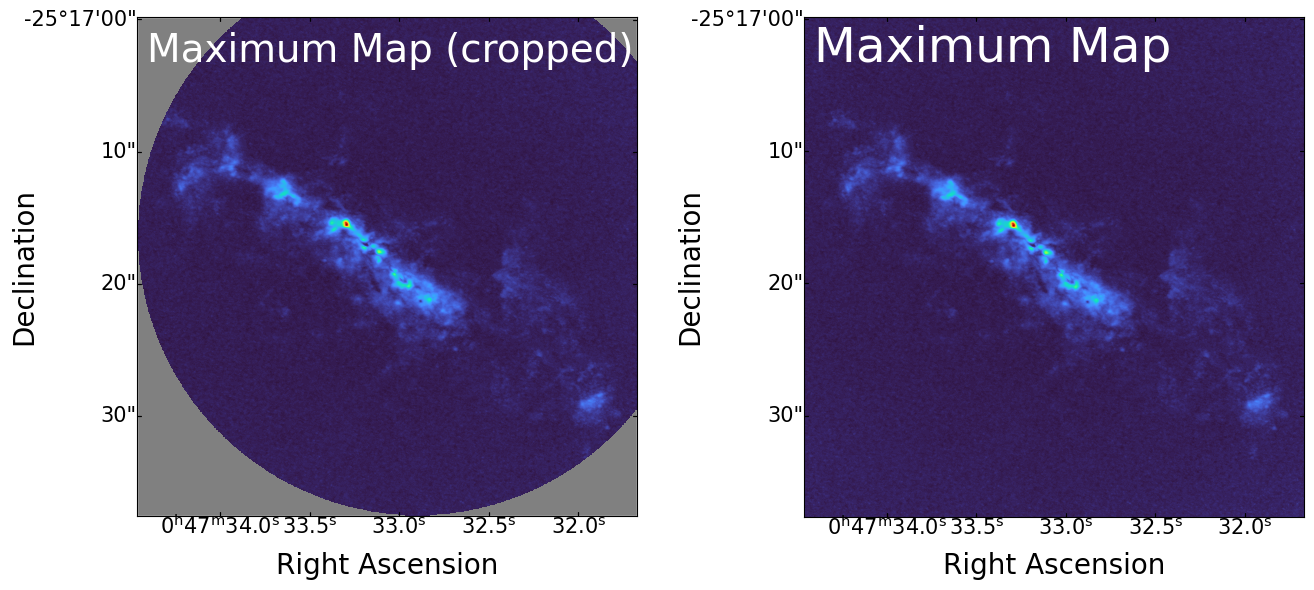

In [220]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction", color='white')

fig1.tight_layout(pad=12.0)


### Cropping HCN 4-3 Transition

In [221]:
HCN43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/HCN4-3.fits.velocity.fits'
                    
image = fits.getdata(HCN43_path)      
header = fits.getheader(HCN43_path)  

In [222]:
HCN43_data = fits.open(HCN43_path)  # Open the FITS file for reading
cube = SpectralCube.read(HCN43_data)  # Initiate a SpectralCube
HCN43_data.close() 
cube

SpectralCube with shape=(81, 1536, 1800) and unit=Jy / beam:
 n_x:   1800  type_x: RA---SIN  unit_x: deg    range:    11.878802 deg:   11.897042 deg
 n_y:   1536  type_y: DEC--SIN  unit_y: deg    range:   -25.295373 deg:  -25.281302 deg
 n_s:     81  type_s: VRAD      unit_s: km / s  range:       43.000 km / s:     443.000 km / s

In [223]:
# Crop HCN 4-3 Datacube to Same Region
sc_HCN43 = SpectralCube.read(HCN43_path)
crop_HCN43 = sc_HCN43.subcube_from_regions(region)

In [224]:
crop_HCN43_kms = crop_HCN43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_HCN43_slab = crop_HCN43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities

In [225]:
crop_HCN43_slab.allow_huge_operations=True
crop_HCN43_K_kms = crop_HCN43_slab.to(u.K) 

max_HCN43_crop   = crop_HCN43_K_kms.apply_numpy_function(np.nanmax,axis=0)

max_HCN43_wcs = crop_HCN43_K_kms.wcs
max_HCN43_wcs = max_HCN43_wcs.dropaxis(2)

In [226]:
# Create maximum map of original data (to compare to cropped)
sc_HCN43 = SpectralCube.read(HCN43_path) 
sc_HCN43_kms = sc_HCN43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_HCN43_slab = sc_HCN43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
sc_HCN43_slab.allow_huge_operations=True
sc_HCN43_K_kms = sc_HCN43_slab.to(u.K)
moment_0_HCN43  = sc_HCN43_K_kms.moment(order=0,how='slice')  
max_map_HCN43   = sc_HCN43_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [227]:
#Write the new, cropped cube to a file
crop_HCN43_K_kms.hdu.writeto('crop_HCN_4-3.cube.fits', overwrite=True) 

Text(0.02, 0.91, 'Maximum Map')

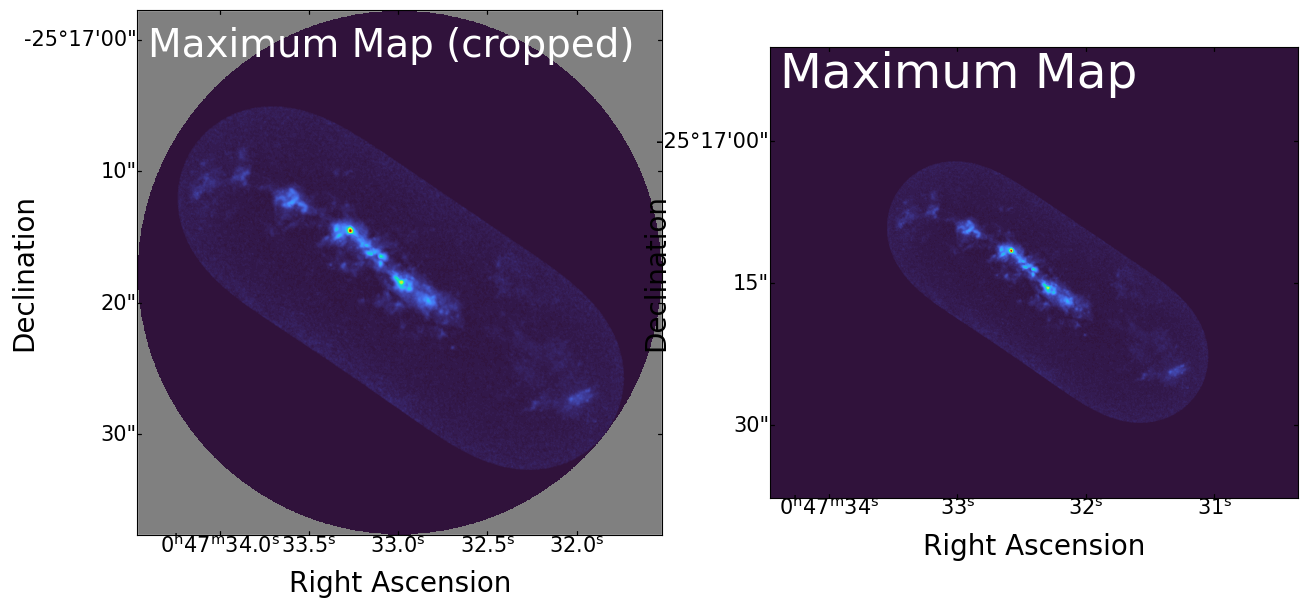

In [228]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_HCN43_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map_HCN43.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction",color='white')


### Cropping H13CN J1-0 Transition

In [229]:
H13CN_10_path = '/Users/ashleylieber/MIlls_Research/NGC253_AlmaData/H13CN_J1-0.cube.fits'
                    
image = fits.getdata(H13CN_10_path)      
header = fits.getheader(H13CN_10_path)

In [230]:
H13CN_10_data = fits.open(H13CN_10_path)  # Open the FITS file for reading
cube = SpectralCube.read(H13CN_10_data)  # Initiate a SpectralCube
H13CN_10_data.close() 
cube

SpectralCube with shape=(180, 1221, 1221) and unit=Jy / beam:
 n_x:   1221  type_x: RA---SIN  unit_x: deg    range:    11.881963 deg:   11.893582 deg
 n_y:   1221  type_y: DEC--SIN  unit_y: deg    range:   -25.293789 deg:  -25.283283 deg
 n_s:    180  type_s: VRAD      unit_s: m / s  range:   -27400.857 m / s:  579633.271 m / s

In [231]:
# Crop H13CN J1-0 Datacube to Same Region
sc_H13CN_10 = SpectralCube.read(H13CN_10_path)
crop_H13CN_10 = sc_H13CN_10.subcube_from_regions(region)

In [232]:
crop_H13CN_10_kms = crop_H13CN_10.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_H13CN_10_slab = crop_H13CN_10_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities

In [233]:
crop_H13CN_10_slab.allow_huge_operations=True
crop_H13CN_10_K_kms = crop_H13CN_10_slab.to(u.K) 

max_H13CN_10_crop   = crop_H13CN_10_K_kms.apply_numpy_function(np.nanmax,axis=0)

max_H13CN_10_wcs = crop_H13CN_10_K_kms.wcs
max_H13CN_10_wcs = max_H13CN_10_wcs.dropaxis(2)

In [234]:
# Create maximum map of original data (to compare to cropped)
sc_H13CN_10 = SpectralCube.read(H13CN_10_path) 
sc_H13CN_10_kms = sc_H13CN_10.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_H13CN_10_slab = sc_H13CN_10_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
sc_H13CN_10_slab.allow_huge_operations=True
sc_H13CN_10_K_kms = sc_H13CN_10_slab.to(u.K)
moment_0_H13CN_10  = sc_H13CN_10_K_kms.moment(order=0,how='slice')  
max_map_H13CN_10   = sc_H13CN_10_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [235]:
#Write the new, cropped cube to a file
crop_H13CN_10_K_kms.hdu.writeto('crop_H13CN_1-0.cube.fits', overwrite=True) 

Text(0.02, 0.91, 'Maximum Map')

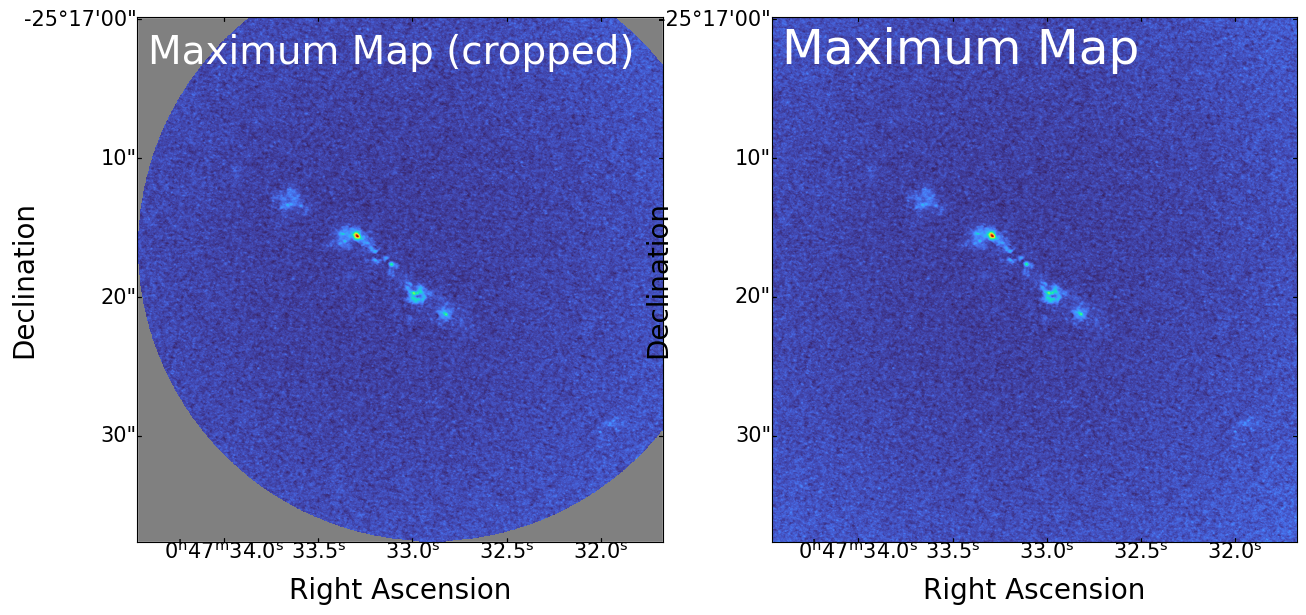

In [236]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_H13CN_10_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map_H13CN_10.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction",color='white')


### Cropping H13CN 4-3 Transition

In [237]:
H13CN_43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/H13CN4-3.fits.velocity.fits'
                    
image = fits.getdata(H13CN_43_path)      
header = fits.getheader(H13CN_43_path)  

In [238]:
H13CN_43_data = fits.open(H13CN_43_path)  # Open the FITS file for reading
cube = SpectralCube.read(H13CN_43_data)  # Initiate a SpectralCube
H13CN_43_data.close() 
cube

SpectralCube with shape=(81, 1536, 1800) and unit=Jy / beam:
 n_x:   1800  type_x: RA---SIN  unit_x: deg    range:    11.878526 deg:   11.897318 deg
 n_y:   1536  type_y: DEC--SIN  unit_y: deg    range:   -25.295586 deg:  -25.281089 deg
 n_s:     81  type_s: VRAD      unit_s: km / s  range:       43.000 km / s:     443.000 km / s

In [239]:
# Crop H13CN 4-3 Datacube to Same Region
sc_H13CN_43 = SpectralCube.read(H13CN_43_path)
crop_H13CN_43 = sc_H13CN_43.subcube_from_regions(region)

In [240]:
crop_H13CN_43_kms = crop_H13CN_43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_H13CN_43_slab = crop_H13CN_43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities

In [241]:
crop_H13CN_43_slab.allow_huge_operations=True
crop_H13CN_43_K_kms = crop_H13CN_43_slab.to(u.K) 

max_H13CN_43_crop   = crop_H13CN_43_K_kms.apply_numpy_function(np.nanmax,axis=0)

max_H13CN_43_wcs = crop_H13CN_43_K_kms.wcs
max_H13CN_43_wcs = max_H13CN_43_wcs.dropaxis(2)

In [242]:
# Create maximum map of original data (to compare to cropped)
sc_H13CN_43 = SpectralCube.read(H13CN_43_path) 
sc_H13CN_43_kms = sc_H13CN_43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_H13CN_43_slab = sc_H13CN_43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
sc_H13CN_43_slab.allow_huge_operations=True
sc_H13CN_43_K_kms = sc_H13CN_43_slab.to(u.K)
moment_0_H13CN_43  = sc_H13CN_43_K_kms.moment(order=0,how='slice')  
max_map_H13CN_43   = sc_H13CN_43_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [243]:
#Write the new, cropped cube to a file
crop_H13CN_43_K_kms.hdu.writeto('crop_H13CN_4-3.cube.fits', overwrite=True) 

Text(0.02, 0.91, 'Maximum Map')

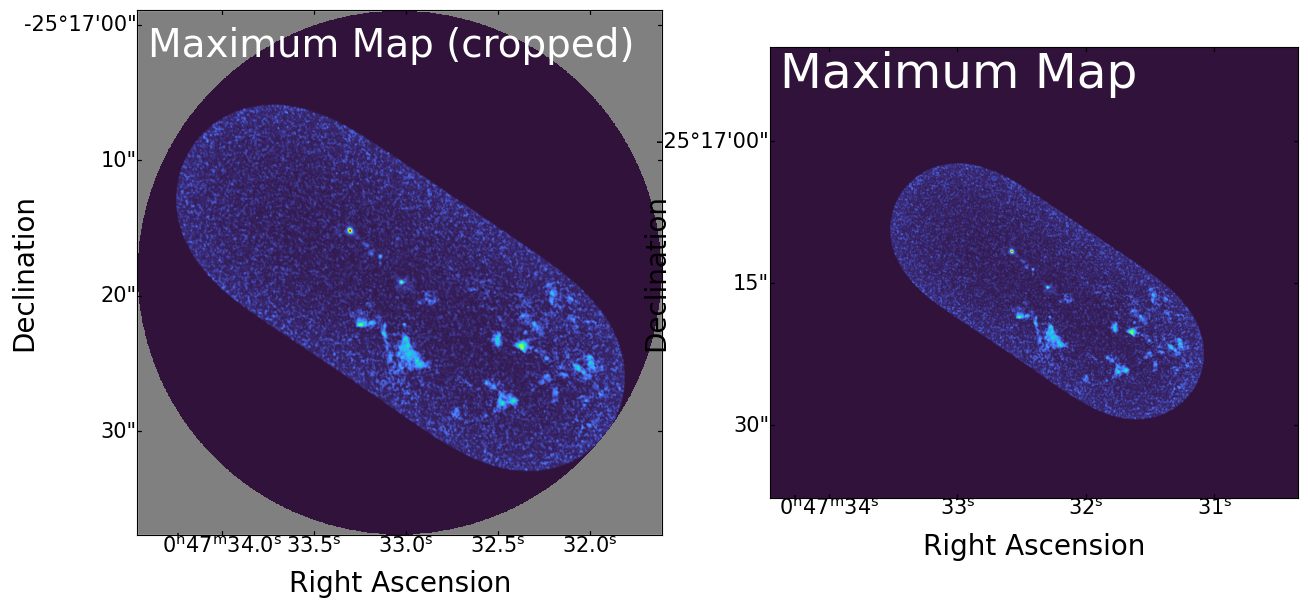

In [244]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_H13CN_43_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map_H13CN_43.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction",color='white')


### Cropping HCO+ 1-0 Transition

In [245]:
HCOp_10_path = '/Users/ashleylieber/MIlls_Research/NGC253_AlmaData/HCOp_J1-0.cube.fits'
                    
image = fits.getdata(HCOp_10_path)      
header = fits.getheader(HCOp_10_path)

In [246]:
HCOp_10_data = fits.open(HCOp_10_path)  # Open the FITS file for reading
cube = SpectralCube.read(HCOp_10_data)  # Initiate a SpectralCube
HCOp_10_data.close() 
cube

SpectralCube with shape=(180, 1221, 1221) and unit=Jy / beam:
 n_x:   1221  type_x: RA---SIN  unit_x: deg    range:    11.881963 deg:   11.893582 deg
 n_y:   1221  type_y: DEC--SIN  unit_y: deg    range:   -25.293789 deg:  -25.283283 deg
 n_s:    180  type_s: VRAD      unit_s: m / s  range:   -27002.594 m / s:  560635.551 m / s

In [247]:
# Crop HCO+ J1-0 Datacube to Same Region
sc_HCOp_10 = SpectralCube.read(HCOp_10_path)
crop_HCOp_10 = sc_HCOp_10.subcube_from_regions(region)

In [248]:
crop_HCOp_10_kms = crop_HCOp_10.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_HCOp_10_slab = crop_HCOp_10_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities

In [249]:
crop_HCOp_10_slab.allow_huge_operations=True
crop_HCOp_10_K_kms = crop_HCOp_10_slab.to(u.K) 

max_HCOp_10_crop   = crop_HCOp_10_K_kms.apply_numpy_function(np.nanmax,axis=0)

max_HCOp_10_wcs = crop_HCOp_10_K_kms.wcs
max_HCOp_10_wcs = max_HCOp_10_wcs.dropaxis(2)

In [250]:
# Create maximum map of original data (to compare to cropped)
sc_HCOp_10 = SpectralCube.read(HCOp_10_path) 
sc_HCOp_10_kms = sc_HCOp_10.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_HCOp_10_slab = sc_HCOp_10_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
sc_HCOp_10_slab.allow_huge_operations=True
sc_HCOp_10_K_kms = sc_HCOp_10_slab.to(u.K)
moment_0_HCOp_10  = sc_HCOp_10_K_kms.moment(order=0,how='slice')  
max_map_HCOp_10   = sc_HCOp_10_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [251]:
#Write the new, cropped cube to a file
crop_HCOp_10_K_kms.hdu.writeto('crop_HCOp_1-0.cube.fits', overwrite=True) 

Text(0.02, 0.91, 'Maximum Map')

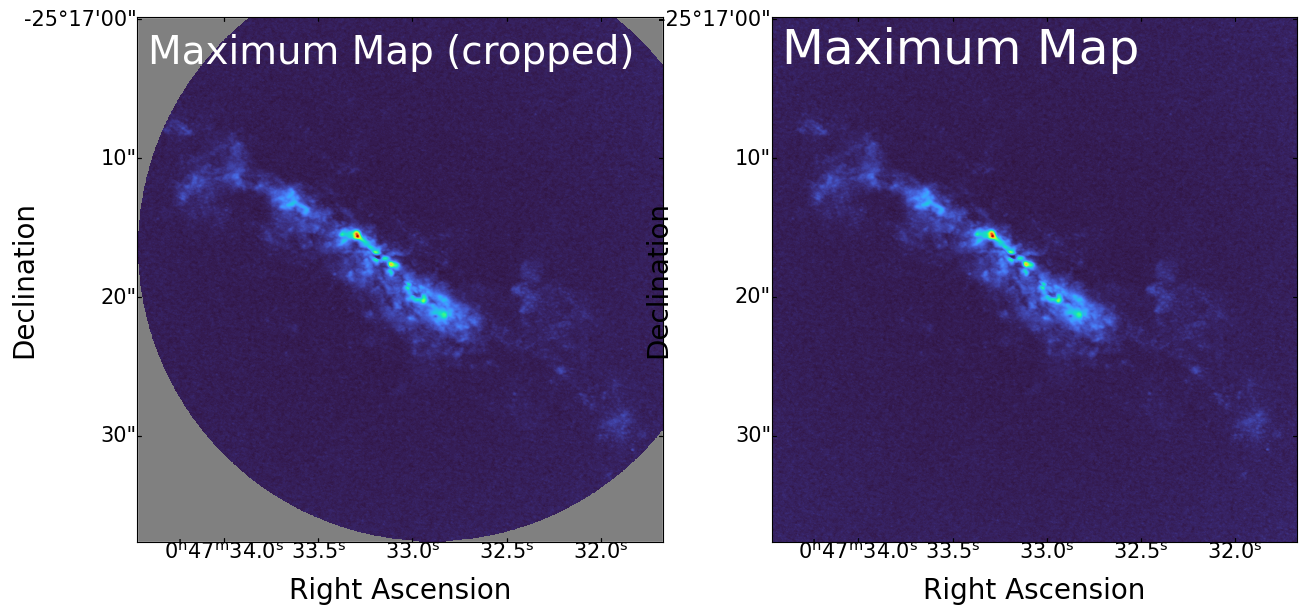

In [252]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_HCOp_10_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map_HCOp_10.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction",color='white')

### Cropping HCO+ 4-3 Transition

In [253]:
HCOp_43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/HCOp4-3.fits.velocity.fits'
                    
image = fits.getdata(HCOp_43_path)      
header = fits.getheader(HCOp_43_path)

In [254]:
HCOp_43_data = fits.open(HCOp_43_path)  # Open the FITS file for reading
cube = SpectralCube.read(HCOp_43_data)  # Initiate a SpectralCube
HCOp_43_data.close() 
cube

SpectralCube with shape=(81, 1536, 1800) and unit=Jy / beam:
 n_x:   1800  type_x: RA---SIN  unit_x: deg    range:    11.878802 deg:   11.897042 deg
 n_y:   1536  type_y: DEC--SIN  unit_y: deg    range:   -25.295373 deg:  -25.281302 deg
 n_s:     81  type_s: VRAD      unit_s: km / s  range:       43.000 km / s:     443.000 km / s

In [255]:
# Crop HCO+ 4-3 Datacube to Same Region
sc_HCOp_43 = SpectralCube.read(HCOp_43_path)
crop_HCOp_43 = sc_HCOp_43.subcube_from_regions(region)

In [256]:
crop_HCOp_43_kms = crop_HCOp_43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
crop_HCOp_43_slab = crop_HCOp_43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities

In [257]:
crop_HCOp_43_slab.allow_huge_operations=True
crop_HCOp_43_K_kms = crop_HCOp_43_slab.to(u.K) 

max_HCOp_43_crop   = crop_HCOp_43_K_kms.apply_numpy_function(np.nanmax,axis=0)

max_HCOp_43_wcs = crop_HCOp_43_K_kms.wcs
max_HCOp_43_wcs = max_HCOp_43_wcs.dropaxis(2)

In [258]:
# Create maximum map of original data (to compare to cropped)
sc_HCOp_43 = SpectralCube.read(HCOp_43_path) 
sc_HCOp_43_kms = sc_HCOp_43.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_HCOp_43_slab = sc_HCOp_43_kms.spectral_slab(-100. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
sc_HCOp_43_slab.allow_huge_operations=True
sc_HCOp_43_K_kms = sc_HCOp_43_slab.to(u.K)
moment_0_HCOp_43  = sc_HCOp_43_K_kms.moment(order=0,how='slice')  
max_map_HCOp_43   = sc_HCOp_43_K_kms.apply_numpy_function(np.nanmax,axis=0)

In [259]:
#Write the new, cropped cube to a file
crop_HCOp_43_K_kms.hdu.writeto('crop_HCOp_4-3.cube.fits', overwrite=True) 

Text(0.02, 0.91, 'Maximum Map')

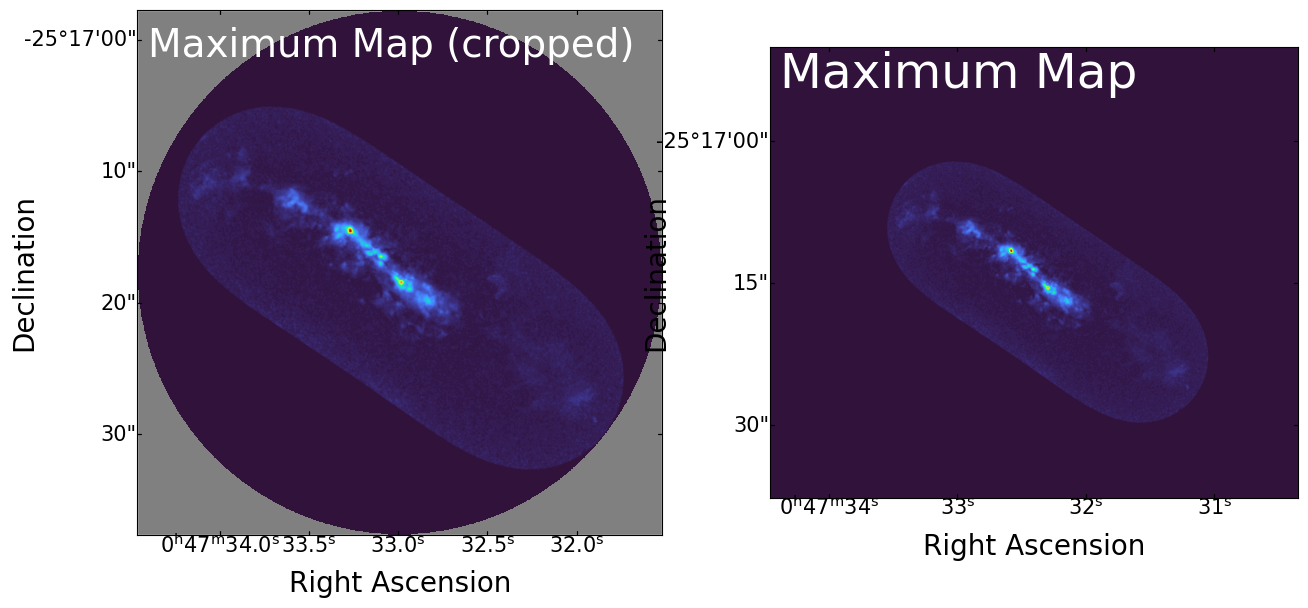

In [260]:
# Compare maxmaps from the original and cropped cubes

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=max_wcs) 
im1 = pylab.imshow(max_HCOp_43_crop.data,cmap='turbo')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.set_facecolor('grey')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)     
pylab.annotate('Maximum Map (cropped)',fontsize=28,xy=(0.02,0.91),xycoords="axes fraction",color='white')  

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map_HCOp_43.data,cmap='turbo')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)   
ax2.set_facecolor('grey')
pylab.annotate('Maximum Map',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction",color='white')